In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent

In [2]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)
len(subset_symbols)

352

In [7]:
dfmpl = get_data("BTCUSDT", interval, limit=20, start_time=int(time.time())*1000-60*10*1000,type="live",offset=60*8000*60) 

In [8]:
dfmpl

,Open,High,Low,Close,Volume
Date,,,,,
2023-08-25 11:09:00,26131.26,26131.27,26128.00,26128.01,5.08226
2023-08-25 11:10:00,26128.01,26128.34,26128.00,26128.33,30.64181
2023-08-25 11:11:00,26128.34,26128.34,26123.43,26123.43,34.78978
2023-08-25 11:12:00,26123.43,26123.91,26121.66,26123.91,28.13572
2023-08-25 11:13:00,26123.91,26126.00,26105.00,26106.00,38.01315
2023-08-25 11:14:00,26106.00,26107.29,26105.99,26107.28,5.18371
2023-08-25 11:15:00,26107.28,26114.00,26107.11,26113.99,6.86220
2023-08-25 11:16:00,26114.00,26124.00,26113.99,26123.99,3.94458
2023-08-25 11:17:00,26123.99,26125.34,26123.99,26124.00,8.34249


In [14]:
3e5

300000.0

In [10]:
#2023-08-25 11:17:00 BTCUSDT  0.0000%, 0.0000%, 1910, 17060
ress={'t': 1692933420000, 'T': 1692933479999, 's': 'BTCUSDT', 'i': '1m', 'f': 3198727474, 'L': 3198727492, 'o': '26123.99000000', 'c': '26124.00000000', 'h': '26124.00000000', 'l': '26123.99000000', 'v': '0.08061000', 'n': 19, 'x': False, 'q': '2105.85531220', 'V': '0.04783000', 'Q': '1249.51092000', 'B': '0'}

In [11]:
df = [ress["t"],float(ress["o"]),float(ress["c"]),float(ress["v"])] 

In [12]:
df

[1692933420000, 26123.99, 26124.0, 0.08061]

In [13]:
df[1]*df[3]

2105.8548339000004

In [10]:
hr25_ago = int(time.time())*1000-3600_000*17
#hr25_ago = 1691460047000 # used for current dataset
hr25_ago

1692336345000

In [11]:
%%time
dfmpl = get_data(tickerpair, interval, limit=1000, start_time=hr25_ago,type="live",offset=60*8000*60) 
dfmpl2 = get_data(tickerpair, interval, limit=1000, start_time=hr25_ago-60*1000*1000,type="live",offset=60*8000*60) 
dfmpl.shape

CPU times: total: 62.5 ms
Wall time: 278 ms


(1000, 5)

In [12]:
dfmpl

,Open,High,Low,Close,Volume
Date,,,,,
2023-08-18 13:26:00,15.22,15.25,15.22,15.25,154.29
2023-08-18 13:27:00,15.25,15.26,15.24,15.24,150.79
2023-08-18 13:28:00,15.25,15.25,15.23,15.24,141.67
2023-08-18 13:29:00,15.23,15.23,15.22,15.23,989.91
2023-08-18 13:30:00,15.24,15.24,15.24,15.24,23.00
...,...,...,...,...,...
2023-08-19 06:01:00,15.42,15.42,15.41,15.41,465.14
2023-08-19 06:02:00,15.41,15.42,15.41,15.42,11.83
2023-08-19 06:03:00,15.42,15.44,15.42,15.44,67.10


In [13]:
%%time 
for iterr in tqdm.tqdm(range(0,50)):
    def worker(ss, ii):
        try:
            tickerpair = ss + "USDT"
            if "USD" in ss:
                return None
            dfmpl = get_data(tickerpair, interval, limit=1000, start_time=hr25_ago-iterr*60*1000*1000,type="live",offset=60*8000*60)
            #print(ss,end=" ")
            return (dfmpl.copy(), tickerpair, ii)
        except ValueError:
            return (None, tickerpair, ii)

    dfmpl_list = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = {executor.submit(worker, ss, ii): (ss, ii) for ii, ss in enumerate(subset_symbols[:])}
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result:
                dfmpl_list.append(result)
    with open(f"2_0_0_analysisdata/2_0_5_dfmpl_list_{iterr:05d}.pkl","wb")as f:
        pickle.dump(dfmpl_list,f)
    time.sleep(5) # should take 25sec per iterr

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [17:48<00:00, 21.36s/it]

CPU times: total: 4min 34s
Wall time: 17min 48s


In [5]:
%%time
#with open("2_0_0dfmpl_list.pkl","wb")as f:
#    pickle.dump(dfmpl_list,f)
with open("2_0_0_analysisdata/2_0_0dfmpl_list.pkl","rb")as f:
    dfmpl_list = pickle.load(f)

CPU times: total: 266 ms
Wall time: 392 ms


In [9]:
dfmpl_list_list = []
for iterr in tqdm.tqdm(range(10)):
    with open(f"2_0_0_analysisdata/2_0_3_dfmpl_list_{iterr:05d}.pkl","rb")as f:
        dfmpl_list = pickle.load(f)
    dfmpl_list_list.append( dfmpl_list.copy())

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.92it/s]


In [33]:
len(dfmpl_list_list[-1])

347

In [12]:
dfmpl_list = dfmpl_list_list[0]
dfmpl,_,_ = dfmpl_list[0]

In [13]:
v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values

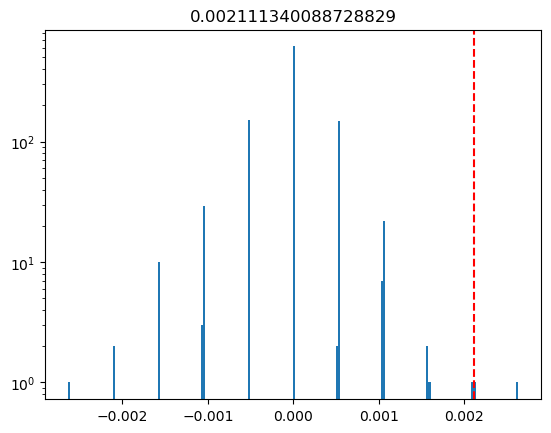

In [14]:
percentile_threshold = np.percentile(v,99.9)
plt.hist(v,bins=200);
plt.axvline(percentile_threshold,ls="--",c="r")
plt.title(percentile_threshold)
plt.yscale("log")

# when price falls twice in a row, 

In [9]:
%%time
threshold=-0.008
dfmpl,tickerpair,indd = dfmpl_list[0]
collated_data_list = []
all_locs = []
for dfmpl,tickerpair,_ in dfmpl_list:
    v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
    a1=np.where(v<threshold)[0]
    a2=np.diff(a1)
    a3=np.where(a2==1)
    def validate_df(loc):
        df_ = dfmpl.iloc[loc:loc+2]
        v0,v1 = (df_.Open*df_.Volume).values
        if v0>3e6 and v1>3e6:
            return True
        return False
    if len(a3)>0:
        locs=a1[a3]
        if len(locs)>0:
            collated_data = np.asarray([v[loc:loc+5] for loc in locs if validate_df(loc)])
            if len(collated_data)>0:
                print(tickerpair,len(collated_data),[loc for loc in locs if validate_df(loc)])
                [all_locs.append(loc)for loc in locs if validate_df(loc)]
                collated_data_list.append(collated_data)
    #len(locs)
collated_data = np.vstack(collated_data_list)
collated_data.shape

XRPUSDT 2 [37812, 37823]
ETHUSDT 1 [48686]
BTCUSDT 1 [48724]
SOLUSDT 2 [37793, 37804]
ARBUSDT 3 [857, 37756, 43944]
DOGEUSDT 7 [15191, 15202, 15244, 15321, 19674, 37648, 39403]
EDUUSDT 2 [101, 102]
CPU times: total: 969 ms
Wall time: 1.39 s


(18, 5)

In [10]:
sorted(all_locs)

[101,
 102,
 857,
 15191,
 15202,
 15244,
 15321,
 19674,
 37648,
 37756,
 37793,
 37804,
 37812,
 37823,
 39403,
 43944,
 48686,
 48724]

Text(0.5, 1.0, 'avg = +0.63%($\\pm$0.94%)')

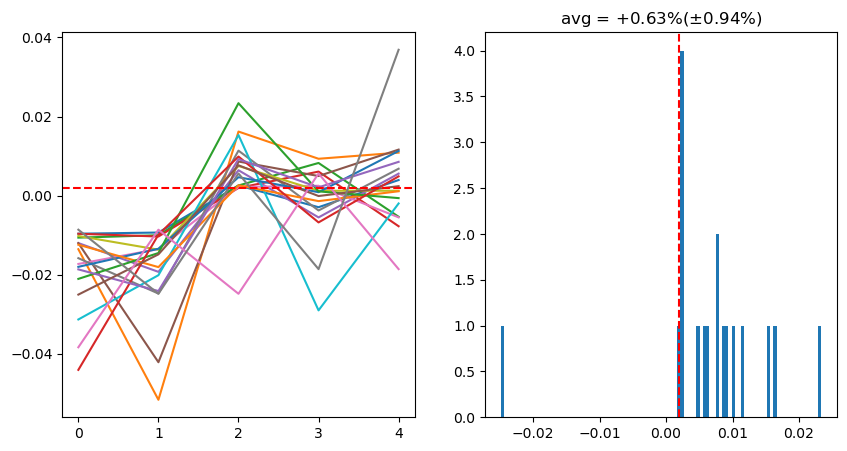

In [11]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
ax.plot(collated_data.T)
ax.axhline(0.002,ls="--",c="r")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")

In [12]:
np.product(collated_data[:,2]+1-0.003)

1.0595611220946755

In [13]:
55000/60/24

38.19444444444444

In [18]:
listt_of_dfs = [1,2,3]

In [19]:
listt_of_dfs.pop(0)

1

In [20]:
listt_of_dfs

[2, 3]

In [21]:
listt_of_dfs.append(4)

In [22]:
listt_of_dfs

[2, 3, 4]

# trading implementation / algo

- subscribe to all data using websockets
- within each websocket instance, fetch data
- maintain a list of previous 2 candles
- once the current candle is determined to be changed, pop the list and append the new candle
    - then apply algorithm onto this list,
    - if criteria passed, send to master_trader.

In [23]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
from binance.enums import *
import time
import datetime
from collections import Counter
import pickle

In [ ]:
master_list=[0 for _ in subset_symbols[:]]
async def main(symbol='BNBBTC',idd=0):
    global master_list
    #time.sleep(idd*)
    await asyncio.sleep(idd*0.25)
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client) 
    ts = bm.kline_socket(symbol, interval=KLINE_INTERVAL_1MINUTE) 
    print(f"sub{idd}",end=" ")
    prev="0000"
    async with ts as tscm:
        while True:
            res = await tscm.recv()
            #print(res)
            if res["e"]=="error":
                print(str(datetime.datetime.now())[11:-4],res)
                raise Exception(res)
            #print(res["k"]["s"],str(res["E"])[6:-3],str(res["k"]["T"])[6:-3],end="  ")
            master_list[idd]=str(res["k"]["T"])[6:-3]
            if idd==0:
                if prev != str(res["k"]["T"])[6:-3]:
                    print(str(datetime.datetime.now())[11:-4],master_list[-3:],Counter(master_list))
                    prev = str(res["k"]["T"])[6:-3]
    await client.close_connection()

In [ ]:
loop = asyncio.get_event_loop()
#loop.run_until_complete(main())
for idd,s in enumerate(subset_symbols[:]):
    asyncio.run_coroutine_threadsafe(main(s+"USDT",idd), loop)
    #time.sleep(0.4)